In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
import healpy as hp
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from readData import *
from nearNeighbors import *
from localBKG import *

In [4]:
# Reads in data files for use in readData.py

hdulist = fits.open('/Users/mtownsend/anaconda/Data/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
hdulist2 = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdulist3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010.fits') # this is one sweep file of the DECaLS data
SpecObj_data = hdulist[1].data
SDSS_data = hdulist2[1].data
DECaLS_data = hdulist3[1].data

length of sdss lrg array:  4851200
length of lrg only array: 1406221
length of row matched targets in SDSS and DECaLS:  4851200
length of DECaLS targets in brick:  4529240
length of id_ALL:  4529240
<class 'numpy.ndarray'>
length of id_MATCHED with LRG_cut (id_LRG): 1528
length of idcut: 4529240
length of idcut = 1 (is an LRG in DECaLS-only file): 1151
length of idcut = 0 (is not an LRG in DECaLS-only file): 4528089
length of z_lrg: 1151


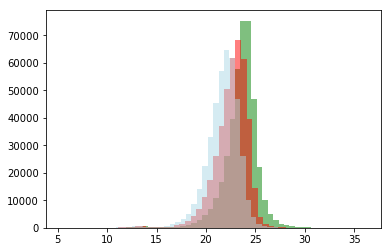

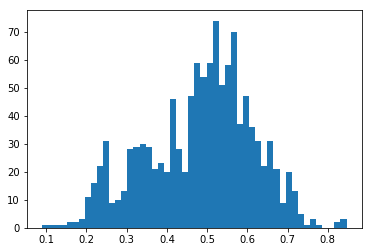

end readData


In [5]:
ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, gmag_BKG, zmag_BKG, color_BKG, rmag_LRG, gmag_LRG, zmag_LRG, color_LRG, z_LRG = readData(SpecObj_data, SDSS_data, DECaLS_data)



In [6]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end co

end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end cosmoCalc
end co

In [10]:
row = 10
column = 10
# creates histogram for survey sources; excludes LRGs
H, xedges, yedges = np.histogram2d(rmag_BKG, color_BKG, normed=False)

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(17.5 * (3600.**2.)) # converts 25 square degrees to square arcseconds

distance = 0.05

distance_kpc, near = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

In [28]:
distance_r2 = 5.
distance_r3 = 100.

numbkg, med_local, sigma, omega, Nbkg, dist_r2, dist_r3, zip_list_LRG, zip_list_BKG = localBKG_and_interlopers(distance_kpc, distance_r2, distance_r3, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

KeyboardInterrupt: 

In [14]:
Nsat = np.array(near) - np.array(Nbkg)
print(len(Nsat))

1151


In [15]:
sumsat, sumsat1z, sumsat2z, sumsat3z, sumsat4z, sumsat5z, sumsat6z, sumsat7z, sumsat1r, sumsat2r, sumsat3r, sumsat4r, sumsat5r, sumsat6r, sumsat7r, sumsat1g, sumsat2g, sumsat3g, sumsat4g, sumsat5g, sumsat6g, sumsat7g, sumsat8g, sumsat1_zmag, sumsat2_zmag, sumsat3_zmag, sumsat4_zmag, sumsat5_zmag, sumsat6_zmag, sumsat7_zmag  = sumNsat(Nsat, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

sumnear, sumnear1z, sumnear2z, sumnear3z, sumnear4z, sumnear5z, sumnear6z, sumnear7z, sumnear1r, sumnear2r, sumnear3r, sumnear4r, sumnear5r, sumnear6r, sumnear7r, sumnear1g, sumnear2g, sumnear3g, sumnear4g, sumnear5g, sumnear6g, sumnear7g, sumnear8g, sumnear1_zmag, sumnear2_zmag, sumnear3_zmag, sumnear4_zmag, sumnear5_zmag, sumnear6_zmag, sumnear7_zmag = sumNN(near, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

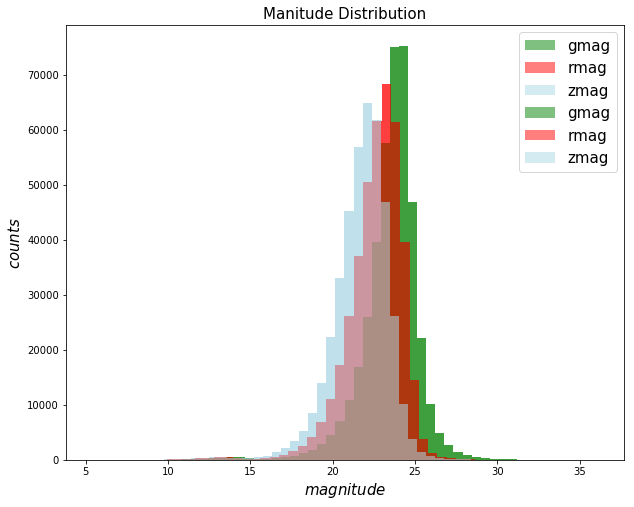

In [17]:
magHist(gmag_BKG, rmag_BKG, zmag_BKG)
plt.show()

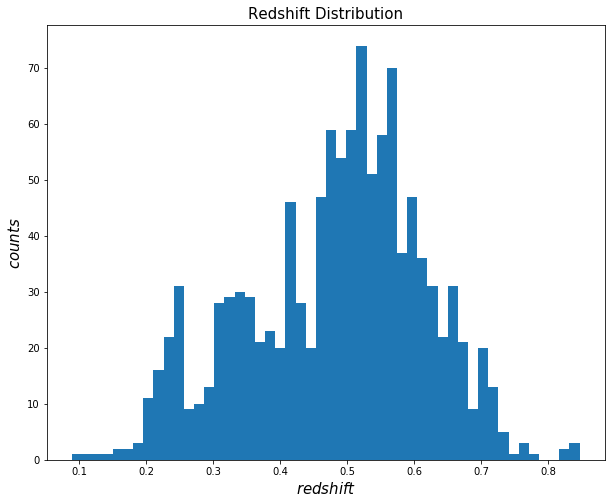

In [18]:
zHist(z_LRG)
plt.show()

mean number of satellites is 0.47895917338959915
median number of satellites is 0.46821428571428575
standard deviation of satellites is 0.9669162854465756


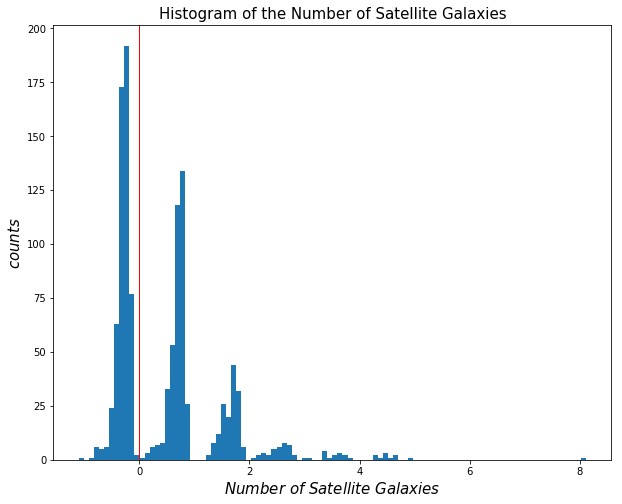

In [20]:
totalNsat(Nsat)
plt.show()

mean number of interlopers is 0.3177393496338588
median number of interlopers is 0.28628571428571425
standard deviation of interloper is 0.1462652246979611


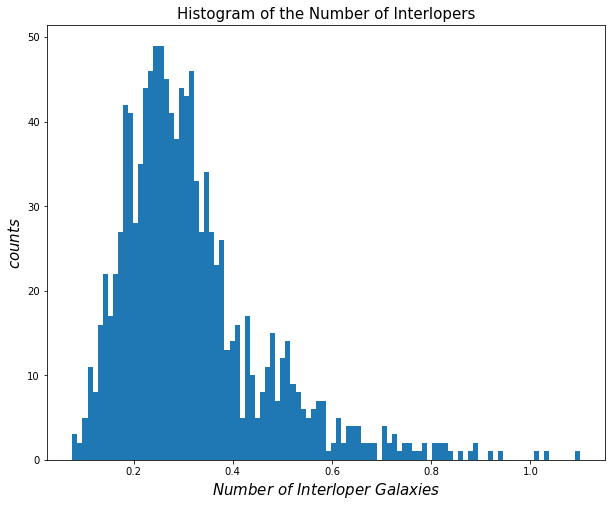

In [19]:
totalNbkg(Nbkg)
plt.show()

mean number of near neighbors is 0.7966985230234579
median number of near neighbors is 1.0
standard deviation of near neighbor is 1.0058160383638575


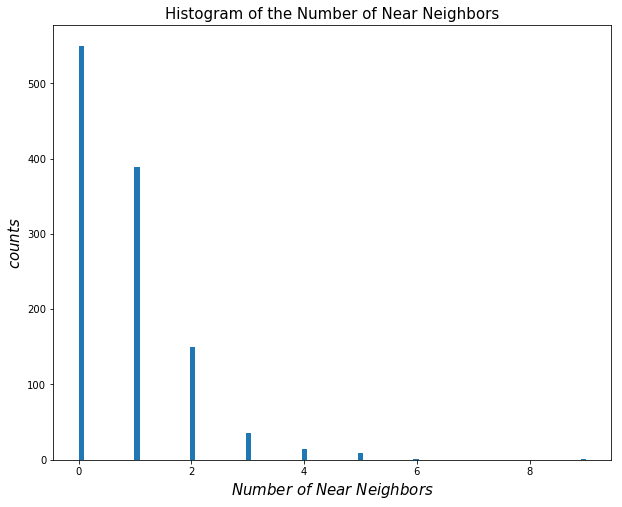

In [21]:
totalNear(near)
plt.show()

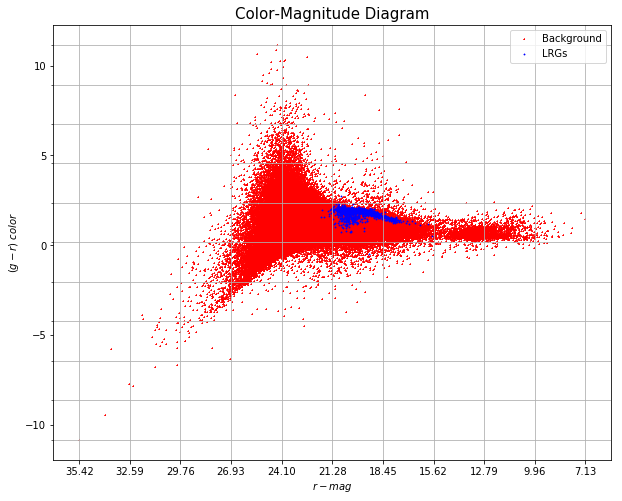

In [22]:
cmd(rmag_BKG, color_BKG, rmag_LRG, color_LRG, xedges, yedges)
plt.show()

The median of Nsat: 0.46821428571428575
The median of bootmed: 0.4687085714285715
Low 68% confidence interval: 0.25951999999999986
High 68% confidence interval: 0.493222857142857


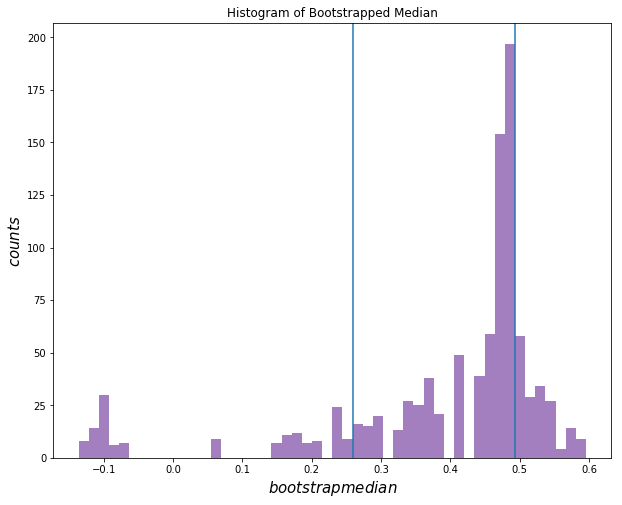

In [23]:
boot_med_plot(1000, 0.68, np.median, sumsat)
plt.show()

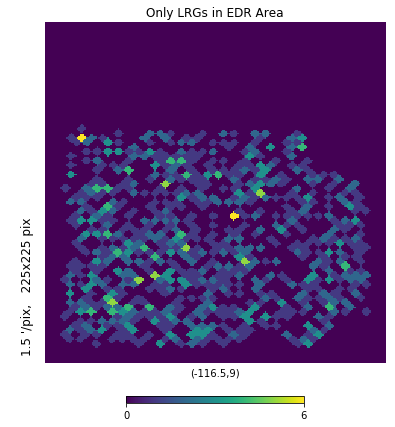

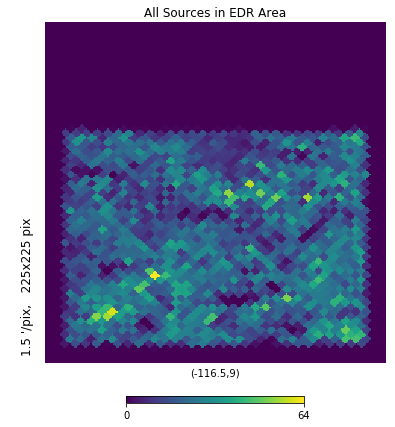

In [24]:
healpix(ra_BKG, dec_BKG, ra_LRG, dec_LRG, gmag_BKG, rmag_BKG, zmag_BKG)
plt.show()

mean number of satellites at z < 0.2: 2.422976428571429
mean number of satellites at 0.2 <= z < 0.3: 1.0777301347708896
mean number of satellites at 0.3 <= z < 0.4: 0.5180801156069365
mean number of satellites at 0.4 <= z < 0.5: 0.4418594863563402
mean number of satellites at 0.5 <= z < 0.6: 0.3808816572928383
mean number of satellites at 0.6 <= z < 0.7: 0.24962846877673223
mean number of satellites at z < 0.7: 0.09431177700348431
total number of Nsat arrays: 1151


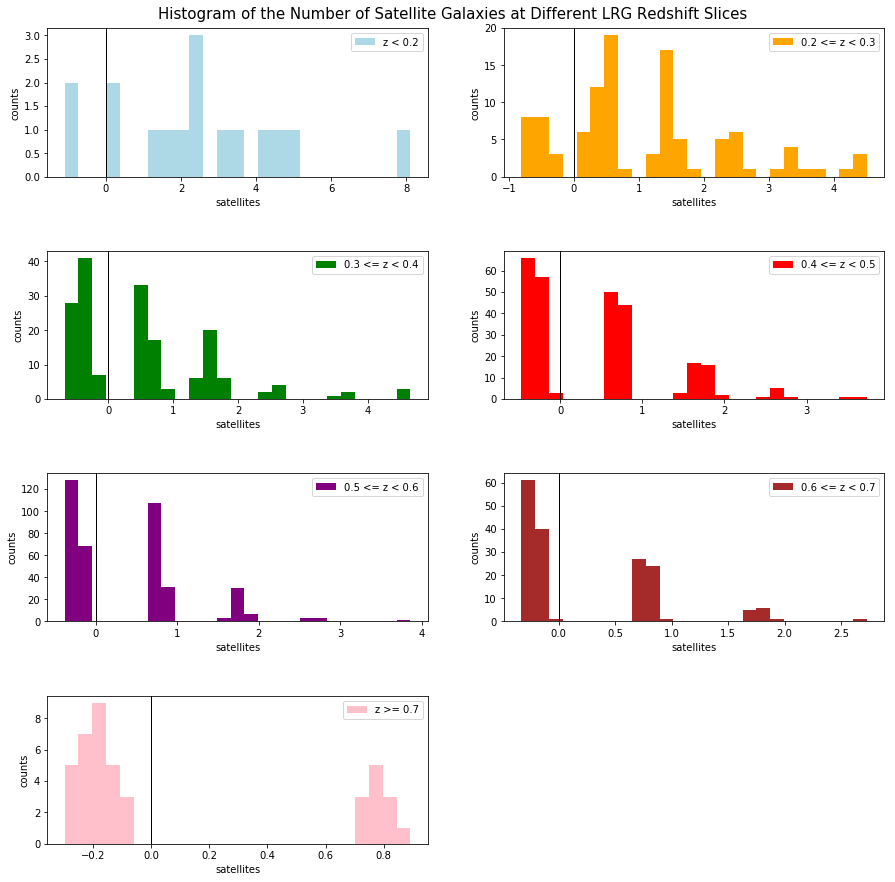

In [25]:
z_cut_Nsat(z_LRG, Nsat)
plt.show()

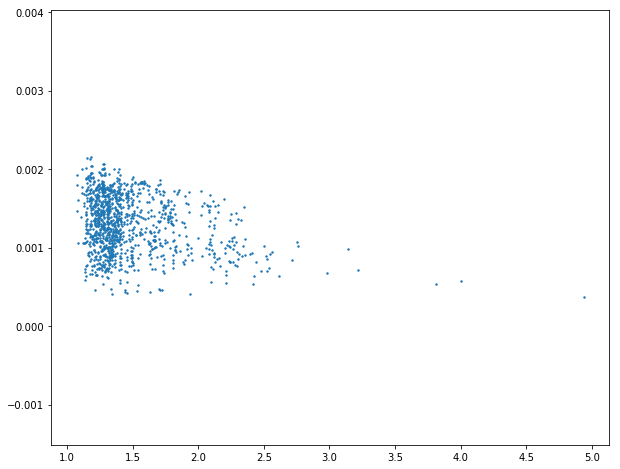

In [27]:
sumsig = []
for i in range(len(sigma)):
    sumsig.append(np.sum(sigma[i]))
    
plt.scatter(dist_r3, sumsig, s = 2)
# plt.ylim((0.,0.001))
plt.show()